In [2]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from pandas import DataFrame
from math import sqrt
from datetime import timedelta

Using TensorFlow backend.


In [3]:
# The path to our CSV file
file = "../data/csv/Gold_Data.csv"
df = pd.read_csv(file)
df.head()
postfitdf = df

In [4]:
#new = old.filter(['A','B','D'], axis=1)

df1 = df.filter(['Date','Gold_Settle', 'Open Interest', 'Money Manager Shorts', 'Money Manager Longs', 'Producer/Merchant/Processor/User Longs', 'Producer/Merchant/Processor/User Shorts'], axis=1)

In [5]:
#raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace = True)

In [6]:
df1.head()

,Gold_Settle,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts
Date,,,,,,
2006-06-13,602.80,382474.0,30916.0,103211.0,42587.0,128892.0
2006-06-20,570.50,390281.0,30963.0,94632.0,47440.0,126992.0
2006-06-27,584.18,384321.0,32287.0,91042.0,48449.0,121890.0
2006-07-03,594.40,392868.0,30452.0,92545.0,48087.0,122568.0
2006-07-11,634.00,427008.0,27624.0,104213.0,54509.0,130618.0


In [7]:
df1.corr()

,Gold_Settle,Open Interest,Money Manager Shorts,Money Manager Longs,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts
Gold_Settle,1.000000,0.713448,0.029547,0.345678,0.338226,0.324827
Open Interest,0.713448,1.000000,0.034981,0.657985,0.284606,0.408501
Money Manager Shorts,0.029547,0.034981,1.000000,-0.444338,-0.286264,-0.706906
Money Manager Longs,0.345678,0.657985,-0.444338,1.000000,-0.029830,0.619795
Producer/Merchant/Processor/User Longs,0.338226,0.284606,-0.286264,-0.029830,1.000000,0.454285
Producer/Merchant/Processor/User Shorts,0.324827,0.408501,-0.706906,0.619795,0.454285,1.000000


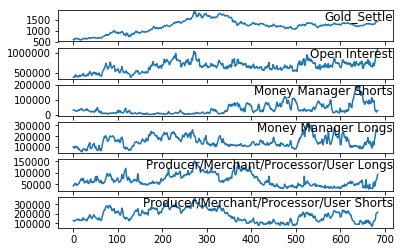

In [8]:
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df1.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.025239   0.000000   0.158664   0.181376   0.110468   0.206973  0.000000
2   0.000000   0.011063   0.158911   0.148317   0.149656   0.200634  0.010690
3   0.010690   0.002617   0.165892   0.134482   0.157804   0.183612  0.018676
4   0.018676   0.014729   0.156217   0.140274   0.154881   0.185874  0.049619
5   0.049619   0.063109   0.141308   0.185238   0.206740   0.212732  0.062903


In [10]:

# split into train and test sets
values = reframed.values
n_train_days = int(len(df1)*.75)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(513, 1, 6) (513,) (171, 1, 6) (171,)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 513 samples, validate on 171 samples
Epoch 1/125
 - 2s - loss: 0.4401 - acc: 0.0019 - val_loss: 0.4601 - val_acc: 0.0000e+00
Epoch 2/125
 - 0s - loss: 0.3593 - acc: 0.0019 - val_loss: 0.3755 - val_acc: 0.0000e+00
Epoch 3/125
 - 0s - loss: 0.2884 - acc: 0.0019 - val_loss: 0.2907 - val_acc: 0.0000e+00
Epoch 4/125
 - 0s - loss: 0.2250 - acc: 0.0019 - val_loss: 0.2030 - val_acc: 0.0000e+00
Epoch 5/125
 - 0s - loss: 0.1726 - acc: 0.0039 - val_loss: 0.1198 - val_acc: 0.0000e+00
Epoch 6/125
 - 0s - loss: 0.1403 - acc: 0.0039 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 7/125
 - 0s - loss: 0.1299 - acc: 0.0039 - val_loss: 0.0370 - val_acc: 0.0000e+00
Epoch 8/125
 - 0s - loss: 0.1311 - acc: 0.0039 - val_loss: 0.0382 - val_acc: 0.0000e+00
Epoch 9/125
 - 0s - loss: 0.1307 - acc: 0.0039 - val_loss: 0.0376 - val_acc: 0.0000e+00
Epoch 10/125
 - 0s - loss: 0.1281 - acc: 0

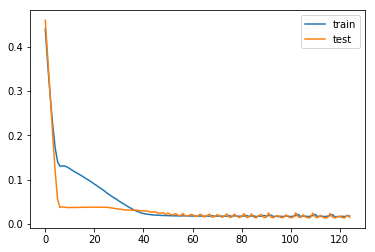

In [11]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=125, batch_size=48, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [12]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


In [13]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 24.217


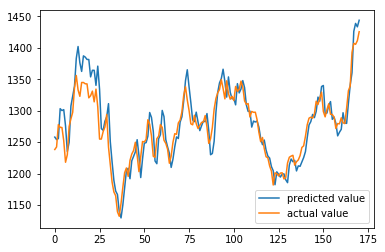

In [14]:
pyplot.plot(inv_yhat, label="predicted value")
pyplot.plot(inv_y, label="actual value")
pyplot.legend()
pyplot.show()

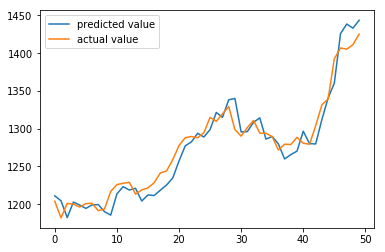

In [15]:
pyplot.plot(inv_yhat[-50:], label="predicted value")
pyplot.plot(inv_y[-50:], label="actual value")
pyplot.legend()
pyplot.show()

In [16]:
inv_yhat[len(inv_yhat)-2]

1433.1506

In [17]:
inv_y[len(inv_y)-1]

1425.34

In [18]:
# The path to our CSV file
file2 = "../data/csv/GoldPrices.csv"
df3 = pd.read_csv(file2)
df4 = df3.filter(['Date','Settle'])
df4['Date'] = pd.to_datetime(df4['Date'])
RelVal = inv_yhat.tolist()
RelVal.reverse()
WklyDate = postfitdf['Date'].iloc[::-1].tolist()
z = {'Date': WklyDate, 'Relative Value': RelVal}
df5 = pd.concat([pd.Series(v, name=k) for k, v in z.items()], axis=1)
df5['Date'] = pd.to_datetime(df5['Date'])

PredictDF = pd.merge(df4, df5, on='Date', how='outer')
FinalPredict_DF = PredictDF.head(len(test_y))
FinalPredict_DF2 = FinalPredict_DF.fillna(method='bfill')

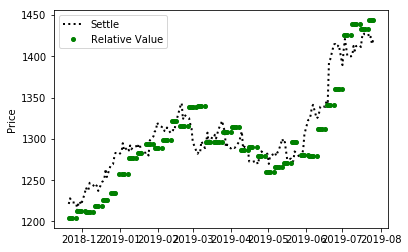

In [19]:
fig = pyplot.figure()
host = fig.add_subplot(111)
host.set_ylabel('Price')

line1, = host.plot(FinalPredict_DF2['Date'], FinalPredict_DF2['Settle'], color='black', linestyle='dotted', linewidth=2)
line2, = host.plot(FinalPredict_DF2['Date'], FinalPredict_DF2['Relative Value'], 'go', markersize=4)
host.legend([line1, line2], ['Settle', 'Relative Value'])

host.xaxis_date()
pyplot.show()

In [20]:
FinalPredict_DF2.head()

,Date,Settle,Relative Value
0,2019-07-26,1419.3,1443.622192
1,2019-07-25,1414.7,1443.622192
2,2019-07-24,1423.6,1443.622192
3,2019-07-23,1421.7,1443.622192
4,2019-07-22,1426.9,1433.150635


In [21]:
for i in range(len(FinalPredict_DF2.index)-3):
    FinalPredict_DF2.at[i,"Relative Value"] = FinalPredict_DF2["Relative Value"][i+3]
FinalPredict_DF2 = FinalPredict_DF2.iloc[:len(FinalPredict_DF2.index)-3]

In [22]:
FinalPredict_DF2.head(20)

,Date,Settle,Relative Value
0,2019-07-26,1419.3,1443.622192
1,2019-07-25,1414.7,1433.150635
2,2019-07-24,1423.6,1433.150635
3,2019-07-23,1421.7,1433.150635
4,2019-07-22,1426.9,1433.150635
5,2019-07-19,1426.7,1433.150635
6,2019-07-18,1428.1,1438.578369
7,2019-07-17,1423.3,1438.578369
8,2019-07-16,1411.2,1438.578369
9,2019-07-15,1413.5,1438.578369


In [23]:
only_fridays = [i for i in range(0,len(FinalPredict_DF2.index)+1,5)]
weekly = FinalPredict_DF2.iloc[only_fridays]
weekly.head(10)

,Date,Settle,Relative Value
0,2019-07-26,1419.3,1443.622192
5,2019-07-19,1426.7,1433.150635
10,2019-07-12,1412.2,1438.578369
15,2019-07-05,1400.1,1360.283203
20,2019-06-27,1412.0,1340.626343
25,2019-06-20,1392.9,1312.094116
30,2019-06-13,1339.2,1279.811157
35,2019-06-06,1337.6,1280.349121
40,2019-05-30,1287.1,1296.720337
45,2019-05-22,1273.6,1270.378174


C:\Users\omara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\omara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\omara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

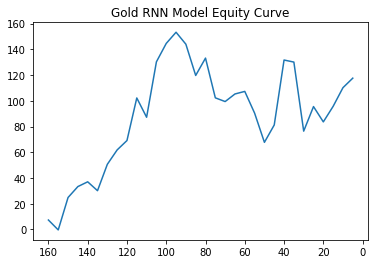

In [30]:
weekly['Settle Delta'] = weekly['Settle'].diff(+1)
weekly['Settle Delta'] = weekly['Settle Delta'].apply(lambda x:x*-1)
weekly['Rel Val Delta'] = weekly['Relative Value'].diff(-1)

Signal = np.sign(weekly['Rel Val Delta'])
weekly2 = pd.concat([weekly, pd.DataFrame(Signal)], axis=1)
weekly2.columns = ['Date', 'Settle', 'Relative Value', 'Settle Delta', 'Rel Val Delta', 'Signal']

weekly2['Profit'] = weekly2['Settle Delta']*weekly2['Signal']
weekly2['EC'] = weekly2.Profit[::-1].cumsum()
fig = plt.figure()
ax = weekly2['EC'].plot(title='Gold RNN Model Equity Curve')
ax.invert_xaxis()
fig.savefig('../graphs/GOLD_DL_EC.png')

In [25]:
weekly2.head(20)

,Date,Settle,Relative Value,Settle Delta,Rel Val Delta,Signal,Profit,EC
0,2019-07-26,1419.3,1443.622192,NaN,10.471558,1.0,NaN,NaN
5,2019-07-19,1426.7,1433.150635,-7.4,-5.427734,-1.0,7.4,117.6
10,2019-07-12,1412.2,1438.578369,14.5,78.295166,1.0,14.5,110.2
15,2019-07-05,1400.1,1360.283203,12.1,19.656860,1.0,12.1,95.7
20,2019-06-27,1412.0,1340.626343,-11.9,28.532227,1.0,-11.9,83.6
25,2019-06-20,1392.9,1312.094116,19.1,32.282959,1.0,19.1,95.5
30,2019-06-13,1339.2,1279.811157,53.7,-0.537964,-1.0,-53.7,76.4
35,2019-06-06,1337.6,1280.349121,1.6,-16.371216,-1.0,-1.6,130.1
40,2019-05-30,1287.1,1296.720337,50.5,26.342163,1.0,50.5,131.7
45,2019-05-22,1273.6,1270.378174,13.5,4.644775,1.0,13.5,81.2


[]